# Learning objectives of this notebook

1. Load simulation output using pandas
2. Plot data and analyse simulation data
3. Pre-treat data for economic analysis
4. Compute LCOH
5. Implement the code for NPV
6. Performa a quick sensitivity analysis as per instructions


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Check for all files in directory
This can come in handy if you have multiple input files later

In [41]:
flist = [os.path.join(dp, n) for dp, dn, fn in os.walk(os.getcwd())
            for n in fn
            if n.endswith('.xlsx')
            and os.path.isfile(os.path.join(dp, n))]


In [42]:
data_hot = pd.read_excel('ATES_10yrs_Martin.xlsx', sheet_name='hotwell_results')
data_hot.drop(columns=['well_P', 'well_Q'], inplace=True)
data_hot = data_hot.add_suffix('_hot')

data_warm = pd.read_excel('ATES_10yrs_Martin.xlsx', sheet_name='warmwell_results')
data_warm.drop(columns=['well_P', 'well_Q'], inplace=True)
data_warm = data_warm.add_suffix('_warm')

data = data_hot.join(data_warm)

In [43]:
flist

['D:\\PyCharm\\SET3205_techno-economics\\ATES_10yrs_Martin.xlsx']

## (later) extend the simulation duration
Extend the simulation duration
Compute the time periods for the data

In [44]:
# # repeat the last year to extend the lifetime
# temp = data.tail(84)
# add_df = pd.concat([temp]*10, ignore_index=True)
# data = pd.concat([data, add_df], ignore_index=True)

# assign timeperiods and years
data['timeperiods'] = range(len(data))
data['years'] = data['timeperiods'] * 365/83.3/365

In [45]:
# set timedelta as index
data.set_index(pd.to_timedelta(data['years'] * pd.Timedelta(('365 days')), unit='s'), inplace=True)

# assign date as column
data['date'] = pd.to_datetime('7/5/2023') + pd.to_timedelta(
                                        data['years'] * pd.Timedelta(('365 days')), unit='s')

# adata the number of periods for further economic assessment
data['econ_periods'] = np.arange(len(data))

# compute the deltahours for economic and energy assessments
data['deltahours'] = data.index.to_series().diff(1) / pd.Timedelta('1 hour')

# verify that we only have one delta
data['deltahours'].unique()

array([         nan, 105.16206483, 105.16206483, 105.16206483,
       105.16206483, 105.16206483, 105.16206483, 105.16206483,
       105.16206483, 105.16206483, 105.16206483, 105.16206483,
       105.16206483, 105.16206483])

In [46]:
# assign well control indicators
data['well control'] = np.where(data['well_Qcalc_hot'] > 0, 'charge', 'discharge')
data['charge'] = np.where(data['well control'] == 'charge', 1, 0)

In [47]:
# Compute power and recovery efficiency

#define columns required for calculating power
powercols = ['Q', 'density', 'cp', 'T']

# compute sum of power for hot and warm wells (in case of multiple wells)
for well in ['hot', 'warm']:
    tt = data.filter(like=well)
    ls = [tt.filter(like=col).columns[0] for col in powercols]
    data[well+' power (MW)'] = tt.loc[:,ls].prod(axis=1)* 1/3600 * 1e-6

# compute net power
data['power net (MW)'] = data['hot power (MW)'] + data['warm power (MW)']


# compute recovery efficiency
data['energy injected (MWh)'] = np.where(data['power net (MW)'] > 0, data['power net (MW)']*data['deltahours'], 0)
data['energy produced (MWh)'] = np.where(data['power net (MW)'] < 0, abs(data['power net (MW)'])*data['deltahours'], 0)
data['recovery efficiency (-)'] = (data['energy produced (MWh)'].cumsum() / data['energy injected (MWh)'].cumsum())



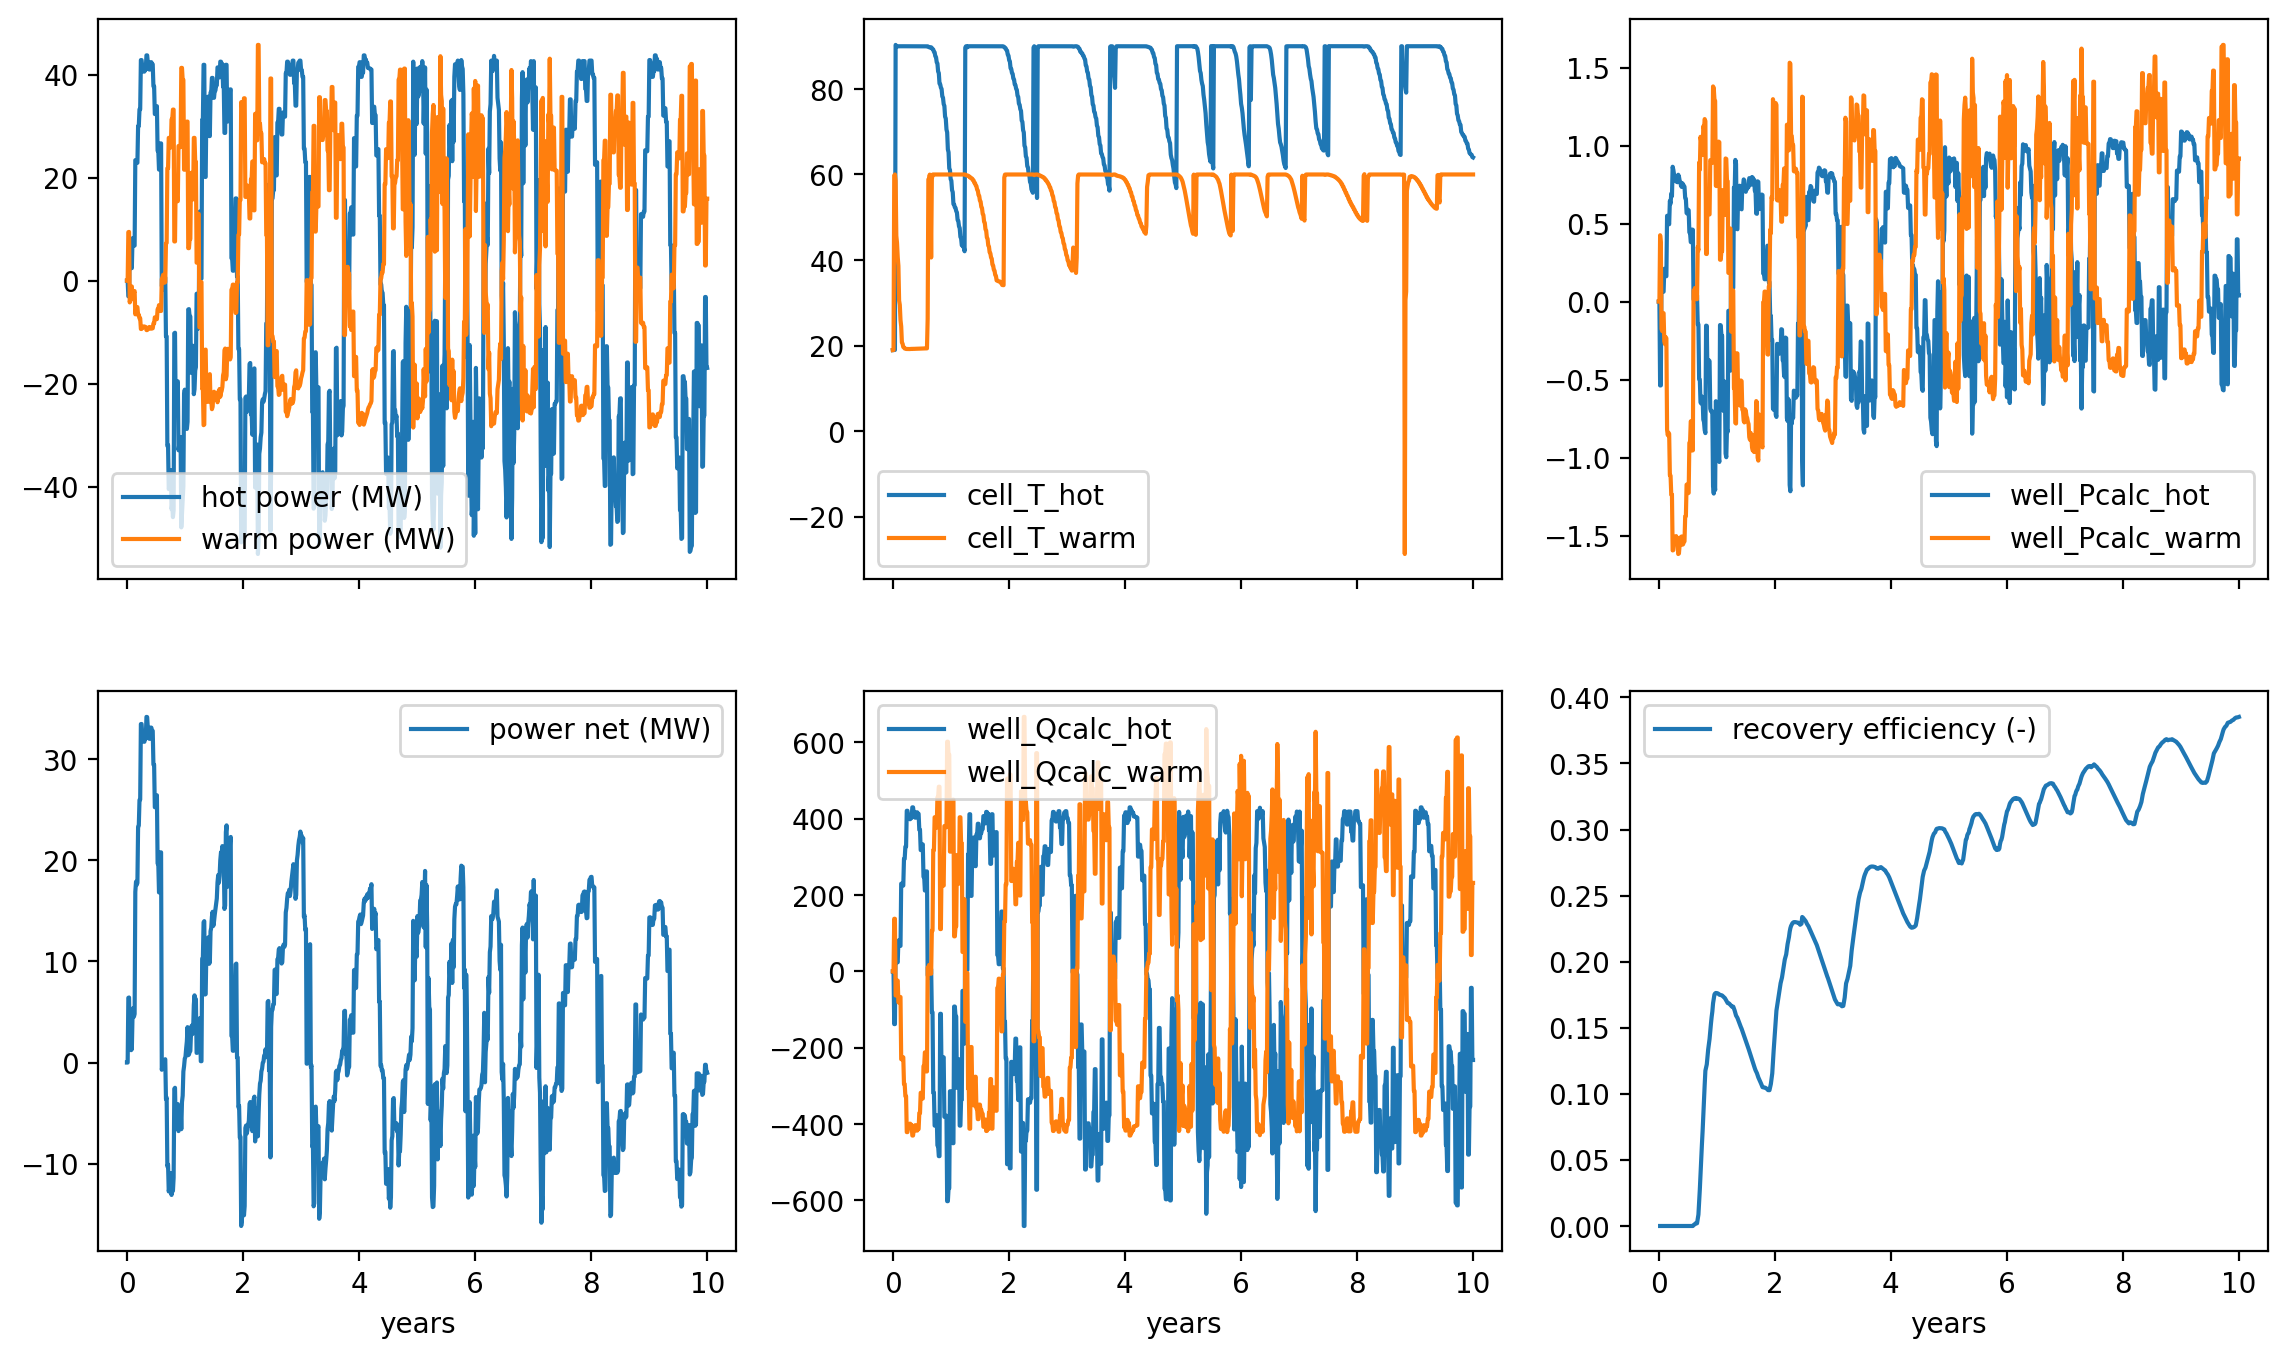

In [48]:
# Make an overview plot of simulation output
fig, ax = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=False, dpi=200)
axx = fig.axes


data.plot(x='years', y=['hot power (MW)', 'warm power (MW)'], ax=axx[0])
data.plot(x='years', y=['cell_T_hot', 'cell_T_warm'], ax=axx[1])
data.plot(x= 'years', y= ['well_Pcalc_hot', 'well_Pcalc_warm'], ax=axx[2])
data.plot(x= 'years', y= 'power net (MW)', ax=axx[3])
data.plot(x= 'years', y = ['well_Qcalc_hot', 'well_Qcalc_warm'], ax=axx[4])
data.plot(x= 'years', y = 'recovery efficiency (-)', ax=axx[5])
# fig.delaxes(ax_list[-1])
set_axes_fontsize = 12

plt.show()

## Compute the required pumping power

In [49]:
<div> <img src="Slides/fig_ploop.PNG" width="800"/></div>

SyntaxError: invalid syntax (1103551320.py, line 1)

In [ ]:
<div> <img src="Slides/fig_ploop.PNG" width="800"/></div>

In [ ]:
# Make an overview plot of simulation output
fig, ax = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=False, dpi=200)
axx = fig.axes


data.plot(x='years', y=['hot power (MW)', 'warm power (MW)'], ax=axx[0])
data.plot(x='years', y=['cell_T_hot', 'cell_T_warm'], ax=axx[1])
data.plot(x= 'years', y= ['well_Pcalc_hot', 'well_Pcalc_warm'], ax=axx[2])
data.plot(x= 'years', y= 'power net (MW)', ax=axx[3])
data.plot(x= 'years', y = ['well_Qcalc_hot', 'well_Qcalc_warm'], ax=axx[4])
data.plot(x= 'years', y = 'recovery efficiency (-)', ax=axx[5])
# fig.delaxes(ax_list[-1])
set_axes_fontsize = 12

plt.show()

<div> <img src="Slides/fig_ploop.PNG" width="800"/></div>

In [ ]:
# compute pumping power

# Compute pressure difference between wells
data['Pump dp (MPa)'] = (abs(data['well_Pcalc_hot'] ) - abs(data['well_Pcalc_warm'])) * 1e-6

# define conversion factors and pump efficiency
m3_day_m3_sec = 1 / (24 * 60 * 60)
pump_efficiency = 0.5

# compute the pumping power
data['Pump power (MW)'] = abs(data['Pump dp (MPa)']) * \
                             abs(data['well_Pcalc_hot']) * m3_day_m3_sec / pump_efficiency

In [ ]:
# compute the pumping costs
electricity_price = 250 # euro/MWh
data['OpEx_pump (\u20ac)'] = data['Pump power (MW)'] * data['deltahours'] * electricity_price


In [ ]:
# assign the CapEx for drilling the wells
data['CapEx (\u20ac)'] = 0
data.loc[data.index == data.index[0], 'CapEx (\u20ac)'] = 2 * 500000

annual_OpEx_rate = 0.03

# compute the year ratio of our time intervals
ratio_year = pd.Timedelta(data['deltahours'].unique()[1], unit='h') / pd.Timedelta('365.25 days')

# compute periodic OpEx rate based on year ration of time intervals
periodic_OpEx_rate = round(((1 + annual_OpEx_rate) ** ratio_year) - 1, 12)

# calculate variable OpEx costs
data['OpEx (\u20ac)'] = data['CapEx (\u20ac)'].cumsum() * periodic_OpEx_rate

<div> <img src="Slides/LCOH_equation.png" width="600"/></div>

In [ ]:
# calculate Levelised Cost of Heat (LCOH)

annual_discount_rate = 0.05

# periodic discount rate
periodic_discount_rate = round(((1 + annual_discount_rate) ** ratio_year) - 1, 12)

# compute the LCOH costs
data['LCOH costs'] = data['CapEx (\u20ac)'].fillna(0) \
                        + data['OpEx (\u20ac)'] \
                          + data['OpEx_pump (\u20ac)'].fillna(0)

# discount LCOH costs
data['discounted LCOH costs'] = (data['LCOH costs'] /
                                      (1 + periodic_discount_rate) ** data['econ_periods']).cumsum()

# discount produced energy
data['discounted LCOH energy'] = (data['energy produced (MWh)'] /
                                        (1 + periodic_discount_rate) ** data[
                                            'econ_periods']).cumsum()

# compute LCOH
data[r'LCOH (€/MWh)'] = data['discounted LCOH costs'] / data['discounted LCOH energy']

In [ ]:
# Plot final result
fig, ax = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=False, dpi=200)
axx = fig.axes


data.plot(x='years', y=['hot power (MW)', 'warm power (MW)'], ax=axx[0])
data.plot(x='years', y=['cell_T_hot', 'cell_T_warm'], ax=axx[1])
data.plot(x= 'years', y= ['well_Pcalc_hot', 'well_Pcalc_warm'], ax=axx[2])
data.plot(x= 'years', y= 'power net (MW)', ax=axx[3])
data.plot(x= 'years', y = 'recovery efficiency (-)', ax=axx[4])
data.plot(x= 'years', y = r'LCOH (€/MWh)', ax=axx[5])
axx[5].annotate('%0.2f @ time: %.2f yrs' % (data[r'LCOH (€/MWh)'].iloc[-1],
                                            data['years'].iloc[-1]),
                            xy=(0.5, 0.5), va='center', ha='center',
                            xycoords=('axes fraction'))
axx[5].set_ylim(0, 200)
# fig.delaxes(ax_list[-1])
set_axes_fontsize = 12

plt.show()

In [ ]:
### Implement the code for NPV calculations
Use a heat price of 15 Euro/MWh and use discount rates of 0%, 5% and 10%

<div> <img src="Slides/NPV_equation.png" width="600"/></div>

### Add 10 and 20 more years

Do this by repeating the last year as many times as needed (see earlier part of the code)
Use a discount rate of 10% for all cases

### Add 10 and 20 more years

Do this by repeating the last year as many times as needed (see earlier part of the code)
Use a discount rate of 10% for all cases